<table align="center">
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/divensambhwani/Face_Detection/blob/master/Face_detection_using_cnn.ipynb">
        <img src="http://introtodeeplearning.com/images/colab/colab.png?v2.0"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/divensambhwani/Face_Detection/blob/master/Face_detection_using_cnn.ipynb">
        <img src="http://introtodeeplearning.com/images/colab/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
 </table>



# Facial Detection Systems

Consider the task of facial detection: given an image, is it an image of a face? 

In [0]:
pip install regex


Let's get started by installing the relevant dependencies:

In [0]:
import tensorflow as tf
tf.enable_eager_execution()

import functools
import matplotlib.pyplot as plt
import numpy as np
import pdb

# Download the class repository
! git clone https://github.com/aamini/introtodeeplearning_labs.git  > /dev/null 2>&1
% cd introtodeeplearning_labs 
! git pull
% cd .. 

# Import the necessary class-specific utility files for this lab
import introtodeeplearning_labs as util

/content/introtodeeplearning_labs
Already up to date.
/content


## 2.1 Datasets

We'll be using three datasets. In order to train our facial detection models, we'll need a dataset of positive examples (i.e., of faces) and a dataset of negative examples (i.e., of things that are not faces). We'll use these data to train our models to classify images as either faces or not faces. Finally, we'll need a test dataset of face images.We'll consider skin tone and gender. 

1.   **Positive training data**: [CelebA Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). A large-scale (over 200K images) of celebrity faces.   
2.   **Negative training data**: [ImageNet](http://www.image-net.org/). Many images across many different categories. We'll take negative examples from a variety of non-human categories. 
3. **Test data**: [Pilot Parliaments Benchmark](http://proceedings.mlr.press/v81/buolamwini18a/buolamwini18a.pdf) (PPB). The PPB dataset consists of images of 1270 male and female parliamentarians from various African and European countries and exhibits parity in both skin tone and gender. The gender of each face is annotated with the sex-based "Male'' and "Female'' labels. Skin tone annotations are based on the Fitzpatrick skin type classification system, with each image labeled as "Lighter'' or "Darker''.

Let's begin by importing these datasets: 

In [4]:
# Get the training data: both images from CelebA and ImageNet
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/l5iqduhe0gwxumq/train_face.h5?dl=1')

1263902720/1263889489 [==============================] - 26s 0us/step


This directly downloads the raw data. We'll call two classes that do a bit of data pre-processing and import the results in a usable format: `TrainingDatasetLoader` for the training data and `PPBFaceEvaluator` for the test data.

Let's create a `TrainingDatasetLoader` and use it to take a look at the training data.

In [0]:
# Instantiate a TrainingDatasetLoader using the downloaded dataset
loader = util.TrainingDatasetLoader(path_to_training_data)

We can look at the size of the training dataset and grab a batch of size 100:

In [0]:
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)

Play around with displaying images to get a sense of what the training data actually looks like!

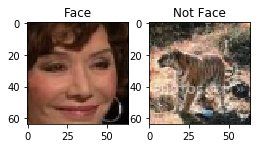

In [0]:
#@title Change the sliders to look at positive and negative training examples! { run: "auto" }

face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

idx_face = 7 #@param {type:"slider", min:0, max:50}
idx_not_face = 38 #@param {type:"slider", min:0, max:50}

plt.figure(figsize=(4,2))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face")
plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face")
plt.grid(False)

We can also create a `PPBFaceEvaluator` instance for the PPB dataset and display some example images. We'll use this dataset later on in the evaluation step.

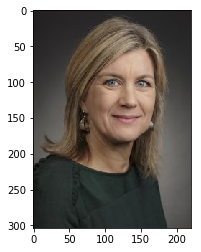

In [0]:
#@title { run: "auto" }

ppb = util.PPBFaceEvaluator(skip=2) # create the dataset handler

gender = "female" #@param ["male", "female"]
skin_color = "lighter" #@param ["lighter", "darker"]

img = ppb.get_sample_faces_from_demographic(gender, skin_color)
plt.imshow(img)

### Thinking about bias

Remember we'll be training our facial detection classifiers on the large, well-curated CelebA dataset (and ImageNet), and then evaluating their accuracy by testing them on the PPB dataset. Our goal is to build a model that trains on CelebA *and* achieves high classification accuracy on PPB across all demographics, and to thus show that this model does not suffer from any hidden bias. 

What exactly do we mean when we say a classifier is biased? In order to formalize this, we'll need to think about [*latent variables*](https://en.wikipedia.org/wiki/Latent_variable), variables that define a dataset but are not strictly observed. We'll use the term *latent space* to refer to the probability distributions of the aforementioned latent variables. Putting these ideas together, we consider a classifier *biased* if its classification decision changes after it sees some additional latent features. This notion of bias may be helpful to keep in mind throughout the rest of the lab. 

## 2.2 CNN for facial detection 

We'll define and train a CNN on the facial classification task, and evaluate its accuracy on the PPB dataset. The CNN model has a relatively standard architecture consisting of a series of convolutional layers with batch normalization followed by two fully connected layers to flatten the convolution output and generate a class prediction. 

### Define and train the CNN model

We'll define our CNN model, and then train on the CelebA and ImageNet datasets using the `tf.GradientTape` class and the `tf.GradientTape.gradient` method.

In [0]:
n_outputs = 1 # number of outputs (i.e., face or not face)
n_filters = 12 # base number of convolutional filters

'''Function to define a standard CNN model'''
def make_standard_classifier():
    Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
    BatchNormalization = tf.keras.layers.BatchNormalization
    Flatten = tf.keras.layers.Flatten
    Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

    model = tf.keras.Sequential([
        Conv2D(filters=1*n_filters, kernel_size=[5,5],  strides=[2,2], input_shape=(64,64,3)),
        BatchNormalization(),
        
        Conv2D(filters=2*n_filters, kernel_size=[5,5],  strides=[2,2]),
        BatchNormalization(),

        Conv2D(filters=4*n_filters, kernel_size=[3,3],  strides=[2,2]),
        BatchNormalization(),

        Conv2D(filters=6*n_filters, kernel_size=[3,3],  strides=[1,1]),
        BatchNormalization(),

        Flatten(),
        Dense(1, activation=None),
        tf.keras.layers.Dropout(0.5)
    ])
    return model
  
standard_classifier = make_standard_classifier()

Now let's train the standard CNN!

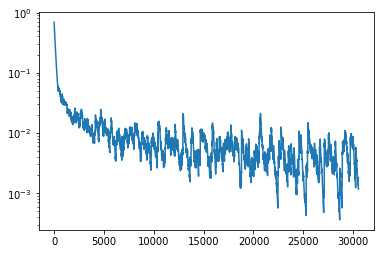

100%|######################################|Time:  0:02:38  Epoch: 9 Loss: 0.00


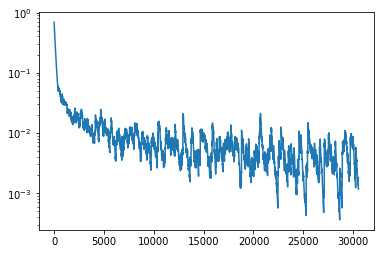

In [0]:
batch_size = 36
num_epochs = 10  # keep small to run faster
learning_rate = 1e-3

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) # define our optimizer
loss_history = util.LossHistory(smoothing_factor=0.99) # to record the evolution of the loss
plotter = util.PeriodicPlotter(sec=2, scale='semilogy')

# The training loop!
for epoch in range(num_epochs):
  
  custom_msg = util.custom_progress_text("Epoch: %(epoch).0f Loss: %(loss)2.2f")
  bar = util.create_progress_bar(custom_msg)
  
  for idx in bar(range(loader.get_train_size()//batch_size)):
    # First grab a batch of training data and convert the input images to tensors
    x, y = loader.get_batch(batch_size)
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    y = tf.convert_to_tensor(y, dtype=tf.float32)
    
    # GradientTape to record differentiation operations
    with tf.GradientTape() as tape:
      logits = standard_classifier(x) # feed the images into the model
      loss_value = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits) # compute the loss

    custom_msg.update_mapping(epoch=epoch, loss=loss_value.numpy().mean())
    # Backpropagation
    grads = tape.gradient(loss_value, standard_classifier.variables)
    optimizer.apply_gradients(zip(grads, standard_classifier.variables), global_step=tf.train.get_or_create_global_step())

    loss_history.append(loss_value.numpy().mean()) 
    plotter.plot(loss_history.get())

### Evaluate performance of the standard CNN

Next, let's evaluate the classification performance of our CelebA-trained standard CNN on the training dataset and the PPB dataset. For the PPB data, we'll look at the classification accuracy across four different demographics defined in PPB: dark-skinned male, dark-skinned female, light-skinned male, and light-skinned female.


In [0]:
# Evaluate on a subset of CelebA+Imagenet
(batch_x, batch_y) = loader.get_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))
print "Standard CNN accuracy on (potentially biased) training set: {:.4f}".format(acc_standard.numpy())

Standard CNN accuracy on (potentially biased) training set: 0.9994


In [0]:
# Evaluate on PPB dataset (takes ~3 minutes)
standard_cnn_accuracy = []
for skin_color in ['lighter', 'darker']:
  for gender in ['male', 'female']:
    standard_cnn_accuracy.append( ppb.evaluate([standard_classifier], gender, skin_color, from_logit=True)[0] )
    print 
    print "{} {}: {}".format(gender, skin_color, standard_cnn_accuracy[-1])

100% (194 of 194) |######################| Elapsed Time: 0:02:30 Time:  0:02:30
N/A% (0 of 147) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


male lighter: 0.958762886598


100% (147 of 147) |######################| Elapsed Time: 0:01:50 Time:  0:01:50
N/A% (0 of 162) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


female lighter: 0.945578231293


100% (162 of 162) |######################| Elapsed Time: 0:01:59 Time:  0:01:59
N/A% (0 of 132) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


male darker: 0.83950617284


100% (132 of 132) |######################| Elapsed Time: 0:01:37 Time:  0:01:37



female darker: 0.916666666667


Text(0,0.5,'Accuracy')

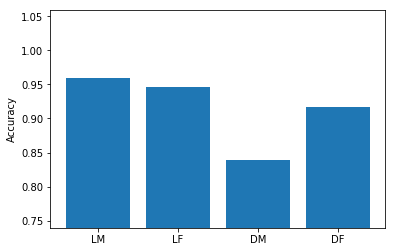

In [0]:
plt.bar(range(4), standard_cnn_accuracy)
plt.xticks(range(4), ('LM', 'LF', 'DM', 'DF'))
plt.ylim(np.min(standard_cnn_accuracy)-0.1,np.max(standard_cnn_accuracy)+0.1)
plt.ylabel('Accuracy')

Take a look at the accuracies for this first model across these four groups. What do you observe? Would you consider this model biased or unbiased, and why? 